In [80]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [81]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [82]:
img = cv2.imread("/content/gdrive/MyDrive/Trabalho Quarta/4.jpg")

imagem = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

tamanho_kernel = (5, 5)

desvio_padrao = (tamanho_kernel[0] - 1) / 2

image = cv2.GaussianBlur(imagem, tamanho_kernel, desvio_padrao)

In [83]:
#Redimensione a imagem (altura e largura) para um múltiplo de 8.

# Obter a altura e largura da imagem
height, width = image.shape[:2]

# Calcular o novo tamanho para ser múltiplo de 8
new_height = height - (height % 8)
new_width = width - (width % 8)

# Redimensionar a imagem para o novo tamanho
resized_image = image[:new_height, :new_width]

In [84]:
#Achar a magnitude e orientação de cada pixel

# Aplicar os filtros para calcular os gradientes
gradient_largura = cv2.filter2D(resized_image, cv2.CV_64F, np.array([[-1, 0, 1]]))
gradient_altura = cv2.filter2D(resized_image, cv2.CV_64F, np.array([[-1], [0], [1]]))

# Calcular a magnitude
magnitude = np.sqrt(gradient_largura ** 2 + gradient_altura ** 2)

# Calcular a orientação
orientation = np.arctan2(gradient_altura, gradient_largura)

# Converter a orientação de radianos para graus
orientation = np.degrees(orientation)

In [85]:
#Dividir a imagem em células de 8x8 pixels
#Para cada célula 8x8, calcula-se um histograma de orientações.

# Calcular o número de células em cada dimensão
num_celulas_largura = new_width // 8
num_celulas_altura = new_height// 8

histogram =  np.zeros((num_celulas_altura, num_celulas_largura, 9),dtype=np.float32)

# Percorrer as células e calcular os histogramas de orientações
for i in range(num_celulas_altura):
    for j in range(num_celulas_largura):

        # Extrair a célula dos gradientes e da orientação
        celula_orientacao = orientation[i*8:(i+1)*8, j*8:(j+1)*8]
        celula_magnitude = magnitude[i*8:(i+1)*8, j*8:(j+1)*8]
        
        # Calcular o histograma de orientações para a célula
        hist, _ = np.histogram(celula_orientacao, bins=9, range=(-np.pi, np.pi), weights=celula_magnitude)

        # Armazena o histograma
        histogram[i,j] = hist

In [86]:
#Agrupe 4 células em um bloco 16x16 (2 células de largura e 2 de altura)
#Normalize os valores de cada bloco utilizando L2

tam_bloco = 16

c_bloco = tam_bloco //8

num_blocos_largura = num_celulas_largura - c_bloco + 1
num_blocos_altura = num_celulas_altura - c_bloco + 1

histogram_blocos =  np.zeros((num_blocos_altura, num_blocos_largura, c_bloco**2 * 9),dtype=np.float32)

for i in range(num_blocos_altura):
    for j in range(num_blocos_largura):

      #Pega celulas
      bloco = histogram[i:i+c_bloco, j:j+c_bloco]

      #Unificando
      new_histogram = bloco.flatten()

      #L2
      new_histogram = c_bloco/ np.sqrt(np.sum(c_bloco**2))

      #Guadar em uma matriz
      histogram_blocos[i,j] = new_histogram

In [87]:
#Descrito Hog é a concatenação dos valores normalizados de cada bloco.

descritor_hog = histogram_blocos.reshape(num_blocos_largura * num_blocos_altura, -1)

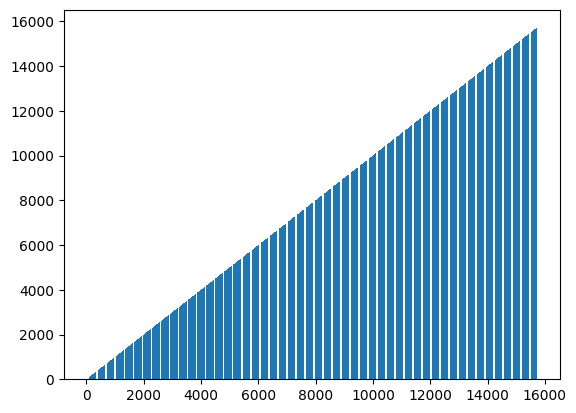

In [88]:
#Para visualizá-lo utiliza-se as orientações nos histogramas das células, feito no passo 3. 

hog_flatted = descritor_hog.flatten()
hog_flatted_len = len(hog_flatted)
descritor_hog_flatted_arange = np.arange(hog_flatted_len)

plt.bar(descritor_hog_flatted_arange, descritor_hog_flatted_arange)
plt.show() 